In [1]:
import pandas as pd
import numpy as np
import string
from string import digits
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.layers import Input, LSTM, Embedding, Dense, Bidirectional, Concatenate, Dot, Activation, TimeDistributed
from keras.models import Model
from keras.utils import plot_model

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
data_path = "/kaggle/input/simple-dialogs-for-chatbot/dialogs.txt"

In [3]:
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
inputs = []
targets = []
num_samples = 10000  # Number of samples to train on.
for line in lines[: min(num_samples, len(lines) - 1)]:

  input, target = line.split('\t')
  inputs.append(input)
  targets.append(target)

In [4]:
lines = pd.DataFrame({'input':inputs, 'target':targets})

In [5]:
lines.shape

(3724, 2)

In [6]:
lines.head()

,input,target
0,"hi, how are you doing?",i'm fine. how about yourself?
1,i'm fine. how about yourself?,i'm pretty good. thanks for asking.
2,i'm pretty good. thanks for asking.,no problem. so how have you been?
3,no problem. so how have you been?,i've been great. what about you?
4,i've been great. what about you?,i've been good. i'm in school right now.


In [7]:
def cleanup(lines):
  # Since we work on word level, if we normalize the text to lower case, this will reduce the vocabulary. It's easy to recover the case later.
  lines.input=lines.input.apply(lambda x: x.lower())
  lines.target=lines.target.apply(lambda x: x.lower())

  # To help the model capture the word separations, mark the comma with special token:
  lines.input=lines.input.apply(lambda x: re.sub("'", '', x)).apply(lambda x: re.sub(",", ' COMMA', x))
  lines.target=lines.target.apply(lambda x: re.sub("'", '', x)).apply(lambda x: re.sub(",", ' COMMA', x))

  # Clean up punctuations and digits. Such special chars are common to both domains, and can just be copied with no error.
  exclude = set(string.punctuation)
  lines.input=lines.input.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))
  lines.target=lines.target.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))

  remove_digits = str.maketrans('', '', digits)
  lines.input=lines.input.apply(lambda x: x.translate(remove_digits))
  lines.target=lines.target.apply(lambda x: x.translate(remove_digits))

In [8]:
st_tok = 'START_'
end_tok = '_END'
def data_prep(lines):
  cleanup(lines)
  lines.target = lines.target.apply(lambda x : st_tok + ' ' + x + ' ' + end_tok)

In [9]:
data_prep(lines)

In [10]:
lines.head()

,input,target
0,hi COMMA how are you doing,START_ im fine how about yourself _END
1,im fine how about yourself,START_ im pretty good thanks for asking _END
2,im pretty good thanks for asking,START_ no problem so how have you been _END
3,no problem so how have you been,START_ ive been great what about you _END
4,ive been great what about you,START_ ive been good im in school right now _END


In [11]:
def tok_split_word2word(data):
  return data.split()

In [12]:
tok_split_fn = tok_split_word2word

In [13]:
def data_stats(lines, input_tok_split_fn, target_tok_split_fn):
  input_tokens=set()
  for line in lines.input:
      for tok in input_tok_split_fn(line):
          if tok not in input_tokens:
              input_tokens.add(tok)

  target_tokens=set()
  for line in lines.target:
      for tok in target_tok_split_fn(line):
          if tok not in target_tokens:
              target_tokens.add(tok)
  input_tokens = sorted(list(input_tokens))
  target_tokens = sorted(list(target_tokens))

  num_encoder_tokens = len(input_tokens)
  num_decoder_tokens = len(target_tokens)
  max_encoder_seq_length = np.max([len(input_tok_split_fn(l)) for l in lines.input])
  max_decoder_seq_length = np.max([len(target_tok_split_fn(l)) for l in lines.target])

  return input_tokens, target_tokens, num_encoder_tokens, num_decoder_tokens, max_encoder_seq_length, max_decoder_seq_length



In [14]:
input_tokens, target_tokens, num_encoder_tokens, num_decoder_tokens, max_encoder_seq_length, max_decoder_seq_length = data_stats(lines, input_tok_split_fn=tok_split_fn, target_tok_split_fn=tok_split_fn)
print('Number of samples:', len(lines))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Number of samples: 3724
Number of unique input tokens: 2338
Number of unique output tokens: 2400
Max sequence length for inputs: 20
Max sequence length for outputs: 22


In [15]:
pad_tok = 'PAD'
sep_tok = ' '
special_tokens = [pad_tok, sep_tok, st_tok, end_tok]
num_encoder_tokens += len(special_tokens)
num_decoder_tokens += len(special_tokens)

In [16]:
def vocab(input_tokens, target_tokens):

  input_token_index = {}
  target_token_index = {}
  for i,tok in enumerate(special_tokens):
    input_token_index[tok] = i
    target_token_index[tok] = i

  offset = len(special_tokens)
  for i, tok in enumerate(input_tokens):
    input_token_index[tok] = i+offset

  for i, tok in enumerate(target_tokens):
    target_token_index[tok] = i+offset

  # Reverse-lookup token index to decode sequences back to something readable.
  reverse_input_tok_index = dict(
      (i, tok) for tok, i in input_token_index.items())
  reverse_target_tok_index = dict(
      (i, tok) for tok, i in target_token_index.items())
  return input_token_index, target_token_index, reverse_input_tok_index, reverse_target_tok_index

In [17]:
input_token_index, target_token_index, reverse_input_tok_index, reverse_target_tok_index = vocab(input_tokens, target_tokens)

In [18]:
max_encoder_seq_length = 30
max_decoder_seq_length = 30

In [19]:
def init_model_inputs(lines, max_encoder_seq_length, max_decoder_seq_length, num_decoder_tokens):
  encoder_input_data = np.zeros(
      (len(lines.input), max_encoder_seq_length),
      dtype='float32')
  decoder_input_data = np.zeros(
      (len(lines.target), max_decoder_seq_length),
      dtype='float32')
  decoder_target_data = np.zeros(
      (len(lines.target), max_decoder_seq_length, num_decoder_tokens),
      dtype='float32')

  return encoder_input_data, decoder_input_data, decoder_target_data

In [20]:
def vectorize(lines, max_encoder_seq_length, max_decoder_seq_length, num_decoder_tokens, input_tok_split_fn, target_tok_split_fn):
  encoder_input_data, decoder_input_data, decoder_target_data = init_model_inputs(lines, max_encoder_seq_length, max_decoder_seq_length, num_decoder_tokens)
  for i, (input_text, target_text) in enumerate(zip(lines.input, lines.target)):
      for t, tok in enumerate(input_tok_split_fn(input_text)):
          encoder_input_data[i, t] = input_token_index[tok]
      encoder_input_data[i, t+1:] = input_token_index[pad_tok]
      for t, tok in enumerate(target_tok_split_fn(target_text)):
          # decoder_target_data is ahead of decoder_input_data by one timestep
          decoder_input_data[i, t] = target_token_index[tok]
          if t > 0:
              # decoder_target_data will be ahead by one timestep
              # and will not include the start character.
              decoder_target_data[i, t - 1, target_token_index[tok]] = 1.
      decoder_input_data[i, t+1:] = target_token_index[pad_tok]
      decoder_target_data[i, t:, target_token_index[pad_tok]] = 1.

  return encoder_input_data, decoder_input_data, decoder_target_data

In [21]:
encoder_input_data, decoder_input_data, decoder_target_data  = vectorize(lines, max_encoder_seq_length, max_decoder_seq_length, num_decoder_tokens, input_tok_split_fn=tok_split_fn, target_tok_split_fn=tok_split_fn)

In [22]:
def seq2seq_attention(num_encoder_tokens, num_decoder_tokens, emb_sz, latent_dim):
    # Define an input sequence and process it.
    encoder_inputs = Input(shape=(None,), dtype='float32')
    encoder_inputs_ = Embedding(num_encoder_tokens, emb_sz, mask_zero=True)(encoder_inputs)    
    
    encoder = Bidirectional(LSTM(latent_dim, return_state=True, return_sequences=True)) # Bi LSTM
    encoder_outputs, state_f_h, state_f_c, state_b_h, state_b_c = encoder(encoder_inputs_)# Bi LSTM
    state_h = Concatenate()([state_f_h, state_b_h])# Bi LSTM
    state_c = Concatenate()([state_f_c, state_b_c])# Bi LSTM

    # We discard `encoder_outputs` and only keep the states.
    encoder_states = [state_h, state_c]# Bi GRU, LSTM, BHi LSTM
    print(encoder_states)
    
    decoder_inputs = Input(shape=(None,))
    decoder_inputs_ = Embedding(num_decoder_tokens, emb_sz, mask_zero=True)(decoder_inputs)    
    # We set up our decoder to return full output sequences,
    # and to return internal states as well. We don't use the
    # return states in the training model, but we will use them in inference.
    decoder_lstm = LSTM(latent_dim*2, return_sequences=True, return_state=True)# Bi LSTM
    
    decoder_outputs, _, _ = decoder_lstm(decoder_inputs_, initial_state=encoder_states)

    # Equation (7) with 'dot' score from Section 3.1 in the paper.
    # Note that we reuse Softmax-activation layer instead of writing tensor calculation
    print(decoder_outputs)
    print(encoder_outputs)
    att_dot = Dot(axes=[2, 2])
    attention = att_dot([decoder_outputs, encoder_outputs])
    att_activation = Activation('softmax', name='attention')
    attention = att_activation(attention)
    print('attention', attention)
    context_dot = Dot(axes=[2,1])
    context = context_dot([attention, encoder_outputs])
    att_context_concat = Concatenate()
    decoder_combined_context = att_context_concat([context, decoder_outputs])

    # Has another weight + tanh layer as described in equation (5) of the paper

    decoder_dense = Dense(num_decoder_tokens, activation='softmax')
    #decoder_outputs = decoder_dense(decoder_outputs)
    decoder_outputs = decoder_dense(decoder_combined_context)

    # Define the model that will turn
    # `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

    model.compile(optimizer=tf.keras.optimizers.Adam(lr = 0.00001), loss='categorical_crossentropy', metrics=['acc'])

    print('encoder-decoder  model:')
    print(model.summary()) 
    
    print(encoder_inputs)
    print(encoder_outputs)
    print(encoder_states)
    encoder_model = Model(encoder_inputs, [encoder_outputs] + encoder_states)

    decoder_encoder_inputs = Input(shape=(None, latent_dim*2,))
    decoder_state_input_h = Input(shape=(latent_dim*2,))# Bi LSTM
    decoder_state_input_c = Input(shape=(latent_dim*2,)) # Bi LSTM
    
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    
    decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs_, initial_state=decoder_states_inputs)

    
    decoder_states = [state_h, state_c]
    
    # Equation (7) with 'dot' score from Section 3.1 in the paper.
    # Note that we reuse Softmax-activation layer instead of writing tensor calculation
    
    attention = att_dot([decoder_outputs, decoder_encoder_inputs])
    
    attention = att_activation(attention)
    
    context = context_dot([attention, decoder_encoder_inputs])
    
    
    
    decoder_combined_context = att_context_concat([context, decoder_outputs])
    
    # Has another weight + tanh layer as described in equation (5) of the paper
    
    decoder_outputs = decoder_dense(decoder_combined_context)
    
    decoder_model = Model(
        [decoder_inputs, decoder_encoder_inputs] + decoder_states_inputs,
        [decoder_outputs, attention] + decoder_states)
    
    return model, encoder_model, decoder_model

In [23]:
emb_sz = 20

[<KerasTensor: shape=(None, 40) dtype=float32 (created by layer 'concatenate')>, <KerasTensor: shape=(None, 40) dtype=float32 (created by layer 'concatenate_1')>]
KerasTensor(type_spec=TensorSpec(shape=(None, None, 40), dtype=tf.float32, name=None), name='lstm_1/PartitionedCall:1', description="created by layer 'lstm_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, None, 40), dtype=tf.float32, name=None), name='bidirectional/concat:0', description="created by layer 'bidirectional'")
attention KerasTensor(type_spec=TensorSpec(shape=(None, None, None), dtype=tf.float32, name=None), name='attention/Softmax:0', description="created by layer 'attention'")
encoder-decoder  model:
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
   

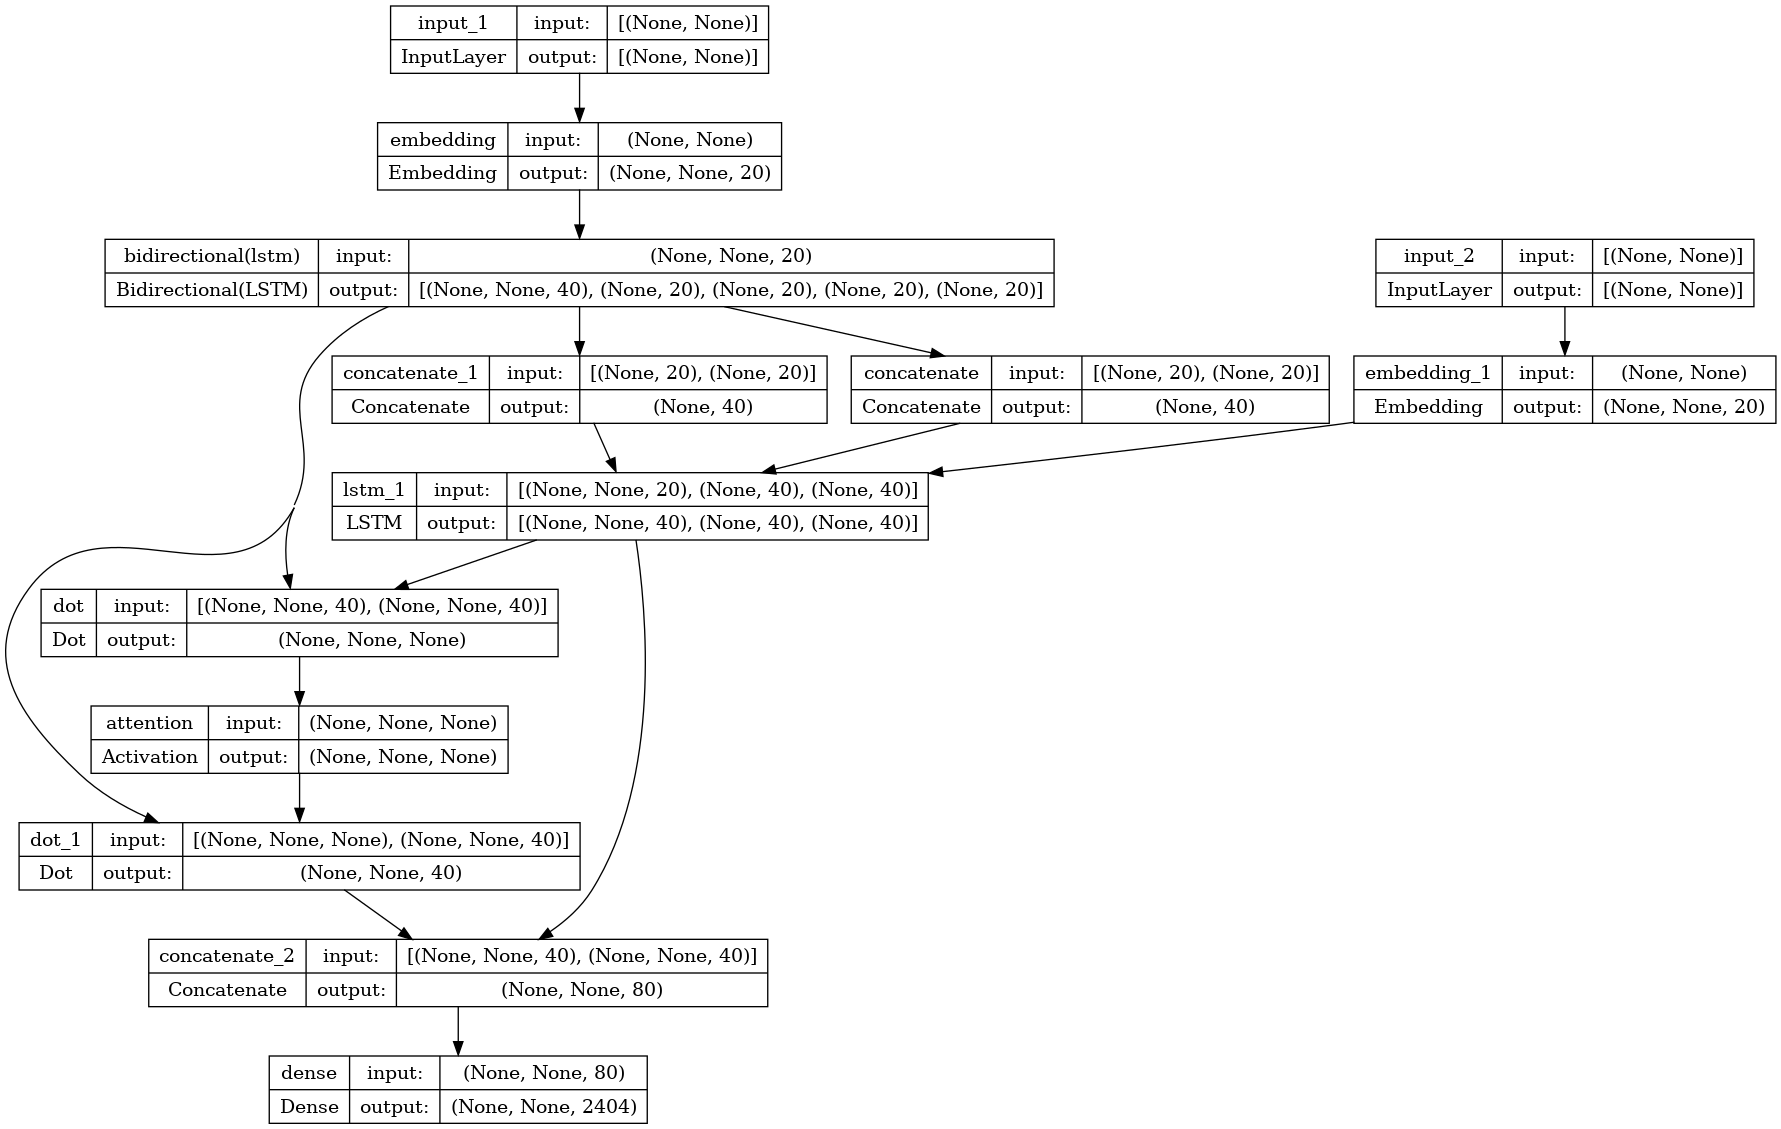

In [24]:
model, encoder_model, decoder_model = seq2seq_attention(num_encoder_tokens, num_decoder_tokens, emb_sz=emb_sz, latent_dim=emb_sz)
print(model.summary())
plot_model(model, show_shapes=True, show_layer_names=True)

In [25]:
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=32,
          epochs=100)

Epoch 1/100
117/117 [==============================] - 30s 122ms/step - loss: 6.3756 - acc: 0.1157
Epoch 2/100
117/117 [==============================] - 7s 57ms/step - loss: 5.2556 - acc: 0.1274
Epoch 3/100
117/117 [==============================] - 4s 37ms/step - loss: 5.0346 - acc: 0.1669
Epoch 4/100
117/117 [==============================] - 4s 32ms/step - loss: 4.8068 - acc: 0.2265
Epoch 5/100
117/117 [==============================] - 4s 36ms/step - loss: 4.6689 - acc: 0.2461
Epoch 6/100
117/117 [==============================] - 3s 29ms/step - loss: 4.5823 - acc: 0.2530
Epoch 7/100
117/117 [==============================] - 4s 31ms/step - loss: 4.5171 - acc: 0.2591
Epoch 8/100
117/117 [==============================] - 4s 35ms/step - loss: 4.4582 - acc: 0.2637
Epoch 9/100
117/117 [==============================] - 3s 29ms/step - loss: 4.4030 - acc: 0.2676
Epoch 10/100
117/117 [==============================] - 3s 28ms/step - loss: 4.3516 - acc: 0.2708
Epoch 11/100
117/117 [=====

In [26]:
def decode_sequence_attention(input_seq, sep=' '):
    # Encode the input as state vectors.
    encoder_outputs, h, c = encoder_model.predict(input_seq)
    states_value = [h,c]
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = target_token_index[st_tok]

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    attention_density = []
    while not stop_condition:
        output_tokens, attention, h, c  = decoder_model.predict(
            [target_seq, encoder_outputs] + states_value)
        attention_density.append(attention[0][0])# attention is max_sent_len x 1 since we have num_time_steps = 1 for the output
        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_tok = reverse_target_tok_index[sampled_token_index]
        decoded_sentence += sep + sampled_tok

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_tok == end_tok or
           len(decoded_sentence) > 52):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]
    attention_density = np.array(attention_density)
    return decoded_sentence, attention_density

In [27]:
lines.input[0]

'hi COMMA how are you doing'

In [28]:
word_decoded_sents = []
for seq_index in range(100): #[14077,20122,40035,40064, 40056, 40068, 40090, 40095, 40100, 40119, 40131, 40136, 40150, 40153]:
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence, attention = decode_sequence_attention(input_seq)
    print('-')
    print('Input sentence:', lines.input[seq_index: seq_index + 1])
    print('Decoded sentence:', decoded_sentence)
    word_decoded_sents.append(decoded_sentence)

1/1 [==============================] - 0s 22ms/step
-
Input sentence: 0    hi COMMA how are you doing
Name: input, dtype: object
Decoded sentence:  nothing what _END
1/1 [==============================] - 0s 24ms/step
-
Input sentence: 1    im fine how about yourself
Name: input, dtype: object
Decoded sentence:  i think it is a good job _END
1/1 [==============================] - 0s 23ms/step
-
Input sentence: 2    im pretty good thanks for asking
Name: input, dtype: object
Decoded sentence:  are you been to you _END
1/1 [==============================] - 0s 26ms/step
-
Input sentence: 3    no problem so how have you been
Name: input, dtype: object
Decoded sentence:  what do you want to go _END
1/1 [==============================] - 0s 23ms/step
-
Input sentence: 4    ive been great what about you
Name: input, dtype: object
Decoded sentence:  i dont know i dont know i want to go to see _END
1/1 [==============================] - 0s 24ms/step
-
Input sentence: 5    ive been good im in s

In [29]:
def calculate_WER_sent(gt, pred):
    '''
    calculate_WER('calculating wer between two sentences', 'calculate wer between two sentences')
    '''
    gt_words = gt.lower().split(' ')
    pred_words = pred.lower().split(' ')
    d = np.zeros(((len(gt_words) + 1), (len(pred_words) + 1)), dtype=np.uint8)
    # d = d.reshape((len(gt_words)+1, len(pred_words)+1))

    # Initializing error matrix
    for i in range(len(gt_words) + 1):
        for j in range(len(pred_words) + 1):
            if i == 0:
                d[0][j] = j
            elif j == 0:
                d[i][0] = i

    # computation
    for i in range(1, len(gt_words) + 1):
        for j in range(1, len(pred_words) + 1):
            if gt_words[i - 1] == pred_words[j - 1]:
                d[i][j] = d[i - 1][j - 1]
            else:
                substitution = d[i - 1][j - 1] + 1
                insertion = d[i][j - 1] + 1
                deletion = d[i - 1][j] + 1
                d[i][j] = min(substitution, insertion, deletion)
    return d[len(gt_words)][len(pred_words)]
def calculate_WER(gt, pred):
    '''

    :param gt: list of sentences of the ground truth
    :param pred: list of sentences of the predictions
    both lists must have the same length
    :return: accumulated WER
    '''
#    assert len(gt) == len(pred)
    WER = 0
    nb_w = 0
    for i in range(len(gt)):
        #print(gt[i])
        #print(pred[i])
        WER += calculate_WER_sent(gt[i], pred[i])
        nb_w += len(gt[i])

    return WER / nb_w

In [30]:
target_sents = list(lines.target[:100])
target_sents = [x[1:-1] for x in target_sents]
word_decoded_sents = [' '.join(x.split()[1:-1]) for x in word_decoded_sents]


In [31]:
WER_word = calculate_WER(target_sents, word_decoded_sents)
print('Word level NMT WER = ', str(WER_word))

Word level NMT WER =  0.19880624426078972
